In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd /content/gdrive/My\ Drive/Game\ of\ Deep\ Learning/images/

/content/gdrive/My Drive/Game of Deep Learning/images


In [0]:
!find . -type f | wc -l

8932


In [0]:
cd /content/gdrive/My\ Drive/Game\ of\ Deep\ Learning/

/content/gdrive/My Drive/Game of Deep Learning


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_ApKoW4T.csv')

In [0]:
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [0]:
test.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


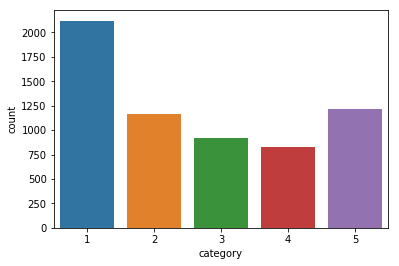

In [0]:
sns.countplot(x="category", data=train),
plt.show()

In [0]:
train['category'].value_counts()

1    2120
5    1217
2    1167
3     916
4     832
Name: category, dtype: int64

In [0]:
train.isnull().sum()

image       0
category    0
dtype: int64

In [0]:
test.isnull().sum()

image    0
dtype: int64

In [0]:
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

A sample image from training set



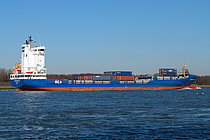

In [0]:
from IPython.display import Image

PATH = "./images/"
print("A sample image from training set\n")
Image(filename = PATH + train["image"][0], width=299, height=299)

A sample image from validation set



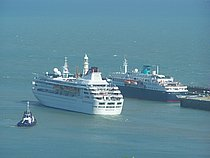

In [0]:
print("A sample image from validation set\n")
Image(filename = PATH + train["image"][5006], width=299, height=299)

A sample image from test set



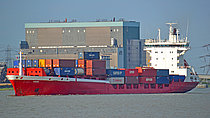

In [0]:
print("A sample image from test set\n")
Image(filename = PATH + test["image"][2000], width=299, height=299)

In [0]:
batch_size = 16

In [0]:
temp = []
for i in range (len(train['category'])):
  local = str(train['category'][i])
  temp.append(local)
train.insert(2, "String_category", temp)

In [0]:
train_generator = datagen.flow_from_dataframe(dataframe=train[:5000], directory="./images/",
                                            x_col="image", y_col="String_category", batch_size=batch_size, shuffle=True, class_mode="categorical", target_size=(299,299))
valid_generator = datagen.flow_from_dataframe(dataframe=train[5000:], directory="./images/",
                                            x_col="image", y_col="String_category", batch_size=batch_size, shuffle=True, class_mode="categorical", target_size=(299,299))
test_generator  = datagen.flow_from_dataframe(dataframe=test, directory="./images/",
                                            x_col="image", batch_size=1, shuffle=False, class_mode=None, target_size=(299,299))

Found 5000 images belonging to 5 classes.
Found 1252 images belonging to 5 classes.
Found 2680 images.


In [0]:
from keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
base_model=InceptionV3(include_top=False,weights='imagenet')
base_model.trainable=False

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.utils.vis_utils import plot_model

plot_model(base_model, to_file='Inception.png')

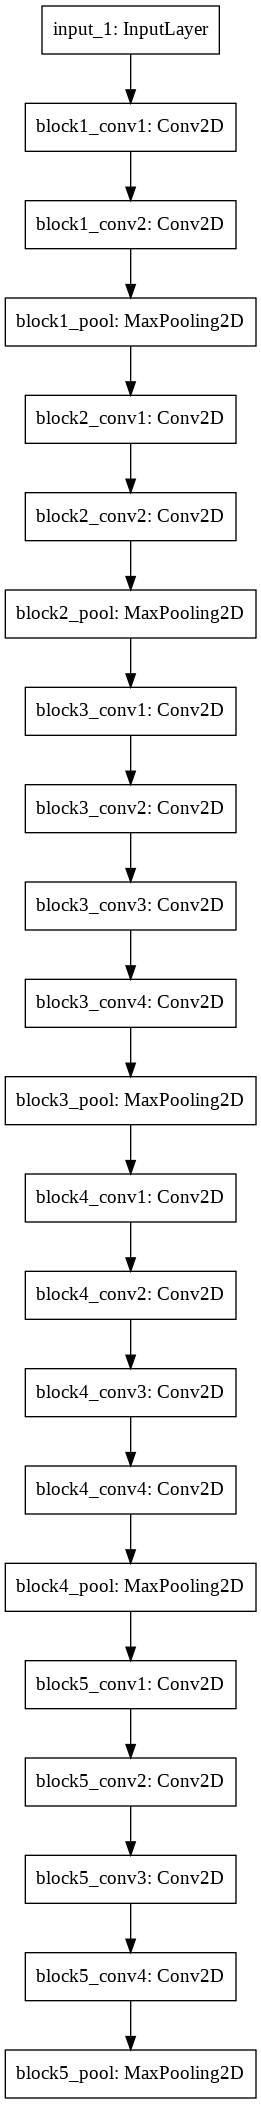

In [0]:
Image(filename = "Inception.png")

In [0]:
from keras.engine.input_layer import Input

pt_features = Input(base_model.get_output_shape_at(0)[1:], name = 'feature_input')
pt_depth = base_model.get_output_shape_at(0)[-1]

In [0]:
from keras.layers import AveragePooling2D, GlobalAveragePooling2D, multiply, Lambda
from keras.models import Model

bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = AveragePooling2D((2,2), strides = (1,1), padding = 'same')(attn_layer) # smooth results
attn_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'softmax')(attn_layer)

# fan it out to all of the channels

up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)

gap_mask = GlobalAveragePooling2D()(attn_layer)

# to account for missing values from the attention model

gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)

gap_features1 = GlobalAveragePooling2D()(mask_features)
gap_mask1 = GlobalAveragePooling2D()(attn_layer)

#to account for missing values from the attention model

gap1 = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features1, gap_mask1])
gap_dr1 = Dropout(0.5)(gap1)

gap_features2 = GlobalAveragePooling2D()(mask_features)
gap_mask2 = GlobalAveragePooling2D()(attn_layer)

gap2 = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features2, gap_mask2])
gap_dr2 = Dropout(0.5)(gap2)

dr_steps = Dropout(0.5)(Dense(128, activation = 'relu')(gap_dr2))
out_layer = Dense(5, activation = 'softmax')(dr_steps)

attn_model = Model(inputs = [pt_features], outputs = [out_layer], name = 'attention_model')

attn_model.compile(optimizer = Adam(lr = 1e-3, beta_1=0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = True),
              loss = 'categorical_crossentropy', metrics = ['accuracy', f1_score])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
attn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      (None, None, None, 5 0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 5 2048        feature_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 65664       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 4128        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [0]:
from keras.models import Sequential

model = Sequential(name = 'combined_model')
model.add(base_model)
model.add(attn_model)
model.compile(optimizer = Adam(lr = 1e-3, beta_1=0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = True),
              loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, None, None, 512)   20024384  
_________________________________________________________________
attention_model (Model)      (None, 5)                 139206    
Total params: 20,163,590
Trainable params: 137,670
Non-trainable params: 20,025,920
_________________________________________________________________


In [0]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('Inception(Attn)Best.hdf5',
                monitor='val_acc', verbose=1, save_best_only=True, 
                save_weights_only=True, mode='max', period=1)

callbacks_list = [checkpoint]


history = model.fit_generator(train_generator, steps_per_epoch=5000 // batch_size, 
                              epochs=100, callbacks=callbacks_list, 
                              validation_data=valid_generator, 
                              validation_steps=1252 // batch_size)


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
312/312 [==============================] - 42s 136ms/step - loss: 1.0469 - acc: 0.5791 - val_loss: 0.6397 - val_acc: 0.7716

Epoch 00001: val_acc improved from -inf to 0.77163, saving model to VGG19(Attn).hdf5
Epoch 2/100
312/312 [==============================] - 41s 132ms/step - loss: 0.8033 - acc: 0.6845 - val_loss: 0.5702 - val_acc: 0.7856

Epoch 00002: val_acc improved from 0.77163 to 0.78560, saving model to VGG19(Attn).hdf5
Epoch 3/100
312/312 [==============================] - 39s 124ms/step - loss: 0.7544 - acc: 0.6941 - val_loss: 0.5485 - val_acc: 0.7896

Epoch 00003: val_acc improved from 0.78560 to 0.78964, saving model to VGG19(Attn).hdf5
Epoch 4/100
312/312 [==============================] - 39s 125ms/step - loss: 0.7141 - acc: 0.7137 - val_loss: 0.5174 - val_acc: 0.7921

Epoch 00004: val_acc improved from 0.78964 to 0.79207, saving mod

In [0]:
model.save('Inception(Attn)-100epochs.h5')

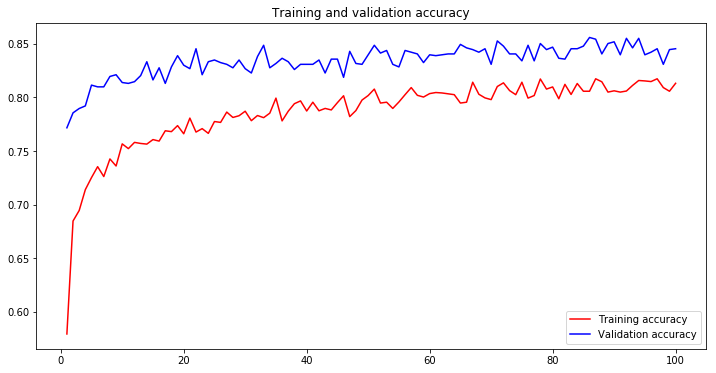

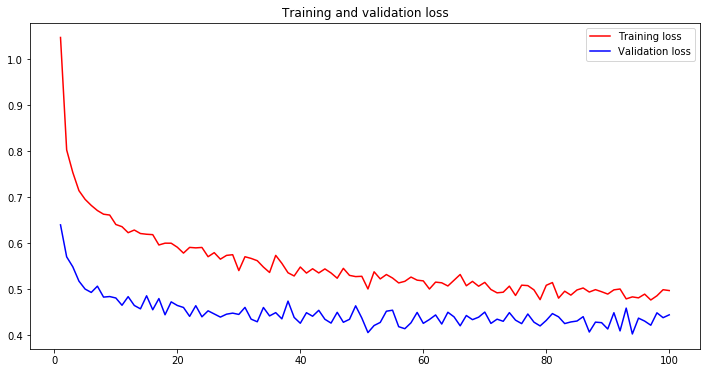

In [0]:
from keras.callbacks import *
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training accuracy')
plt.plot(epochs, val_acc, 'blue', label='Validation accuracy')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()


In [0]:
from keras.models import load_model
model.load_weights('')

In [0]:
submit = pd.read_csv('sample_submission_ns2btKE.csv')
submit.head()

,image,category
0,1007700.jpg,1
1,1011369.jpg,1
2,1051155.jpg,1
3,1062001.jpg,1
4,1069397.jpg,1


In [0]:
submit.drop(columns = ["category"])

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg
5,1072861.jpg
6,1097264.jpg
7,1098763.jpg
8,1098766.jpg
9,1101145.jpg


In [0]:
submit.insert(1, "category", Y_test)

In [0]:
submit.to_csv('submit_InceptionV3(Attn)100epochs.csv')